<a href="https://colab.research.google.com/github/Bruce1998a/Libro---Calidad-de-datos-clim-ticos-con-Machine-Learning/blob/main/Secci%C3%B3n_5_2_relleno_por_media.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cargar Temperatura_diaria.csv**

Ejemplo practico para la sección 5.2 del libro Calidad de datos climáticos con Machine Learning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv("Temperatura_diaria.csv", sep=";")

# Normalizar nombres de columnas
df.columns = df.columns.str.lower().str.strip()

# Convertir fecha (formato día/mes/año)
df["fecha"] = pd.to_datetime(
    df["fecha"],
    dayfirst=True,
    errors="coerce"
)

# Convertir temperatura a numérico
df["temp"] = (
    df["temp"]
    .astype(str)
    .str.replace(",", ".", regex=False)
)

df["temp"] = pd.to_numeric(df["temp"], errors="coerce")

# Ordenar
df = df.sort_values("fecha").reset_index(drop=True)

df.head()


,fecha,temp
0,1982-01-01,25.0410
1,1982-01-02,24.8143
2,1982-01-03,23.9413
3,1982-01-04,23.6070
4,1982-01-05,23.7245


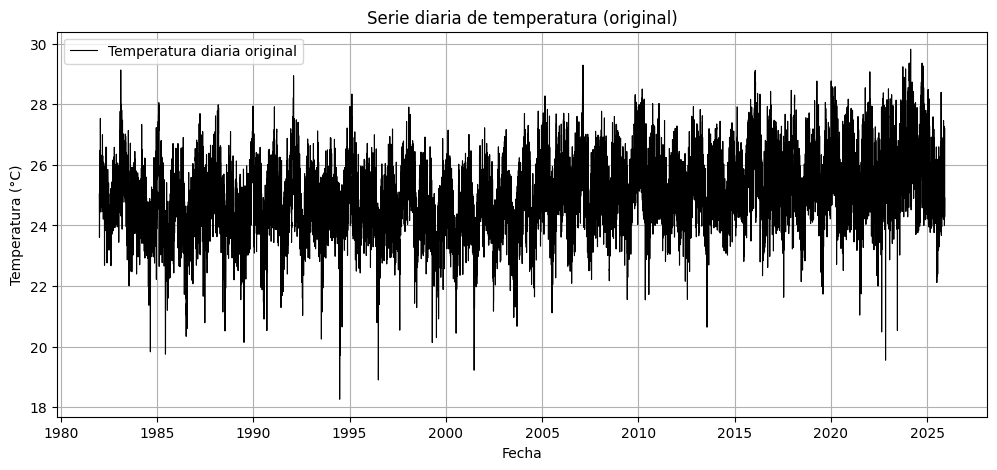

In [ ]:
plt.figure(figsize=(12,5))

plt.plot(
    df["fecha"],
    df["temp"],
    color="black",
    linewidth=0.8,
    label="Temperatura diaria original"
)

plt.xlabel("Fecha")
plt.ylabel("Temperatura (°C)")
plt.title("Serie diaria de temperatura (original)")
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
np.random.seed(42)

porcentaje_faltantes = 0.20

indices_faltantes = df.sample(
    frac=porcentaje_faltantes,
    random_state=42
).index

df["temp_original"] = df["temp"]
df.loc[indices_faltantes, "temp"] = np.nan

print("Datos faltantes tras eliminación artificial:")
print(df["temp"].isna().sum())


Datos faltantes tras eliminación artificial:
3208


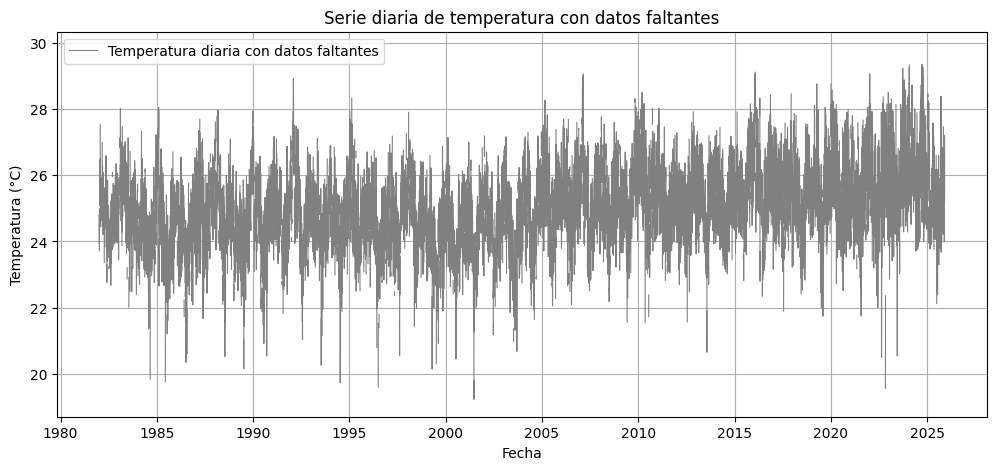

In [ ]:
plt.figure(figsize=(12,5))

plt.plot(
    df["fecha"],
    df["temp"],
    color="gray",
    linewidth=0.8,
    label="Temperatura diaria con datos faltantes"
)

plt.xlabel("Fecha")
plt.ylabel("Temperatura (°C)")
plt.title("Serie diaria de temperatura con datos faltantes")
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
df["dia_anio"] = df["fecha"].dt.dayofyear

media_diaria = (
    df
    .groupby("dia_anio")["temp"]
    .mean()
)

media_diaria


,temp
dia_anio,
1,25.657924
2,25.576800
3,25.606982
4,25.600032
5,25.443849
...,...
362,25.298606
363,25.438245
364,25.513052


In [ ]:
def rellenar_por_media_diaria(row):
    if pd.isna(row["temp"]):
        return media_diaria.loc[row["dia_anio"]]
    else:
        return row["temp"]

df["temp_rellena_media"] = df.apply(
    rellenar_por_media_diaria,
    axis=1
)

print("Datos faltantes tras el relleno:")
print(df["temp_rellena_media"].isna().sum())


Datos faltantes tras el relleno:
0


In [ ]:
# Subconjunto SOLO en los puntos que fueron rellenados
df_eval = df.loc[indices_faltantes].dropna(
    subset=["temp_original", "temp_rellena_media"]
)

print("Número de puntos evaluados:", len(df_eval))


Número de puntos evaluados: 3208


In [ ]:
import numpy as np

# Errores
errores = df_eval["temp_rellena_media"] - df_eval["temp_original"]

mae = np.mean(np.abs(errores))
rmse = np.sqrt(np.mean(errores**2))
bias = np.mean(errores)
corr = df_eval["temp_original"].corr(df_eval["temp_rellena_media"])

print(f"MAE  : {mae:.3f} °C")
print(f"RMSE : {rmse:.3f} °C")
print(f"Bias : {bias:.3f} °C")
print(f"Corr : {corr:.3f}")


MAE  : 0.887 °C
RMSE : 1.132 °C
Bias : 0.014 °C
Corr : 0.402


In [ ]:
stats_original = df_eval["temp_original"].describe()
stats_rellena = df_eval["temp_rellena_media"].describe()

comparacion = pd.concat(
    [stats_original, stats_rellena],
    axis=1
)

comparacion.columns = ["Original", "Rellenada"]

comparacion


,Original,Rellenada
count,3208.000000,3208.000000
mean,25.016382,25.030250
std,1.234566,0.563651
min,18.269300,23.584200
25%,24.212050,24.799731
50%,25.009450,25.211345
75%,25.789025,25.411668
max,29.357400,26.208970


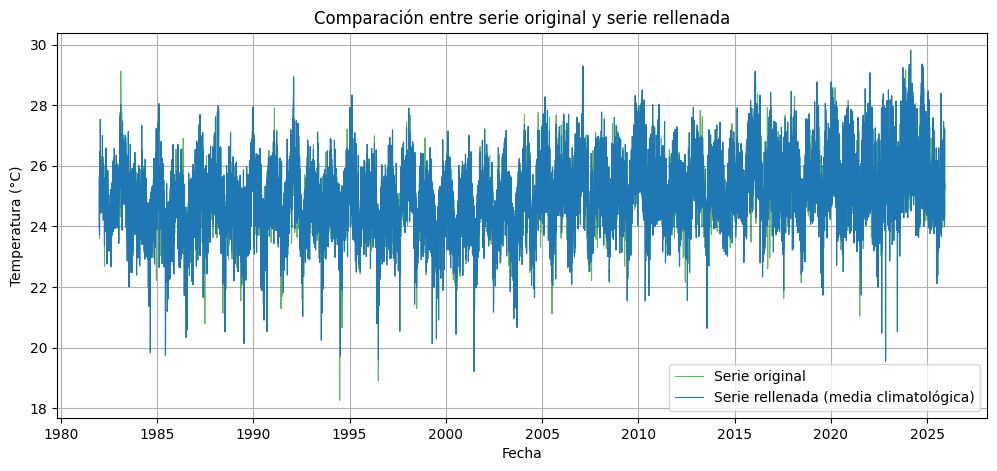

In [ ]:
plt.figure(figsize=(12,5))

plt.plot(
    df["fecha"],
    df["temp_original"],
    color="green",
    linewidth=0.8,
    alpha=0.6,
    label="Serie original"
)

plt.plot(
    df["fecha"],
    df["temp_rellena_media"],
    color="tab:blue",
    linewidth=0.8,
    label="Serie rellenada (media climatológica)"
)

plt.xlabel("Fecha")
plt.ylabel("Temperatura (°C)")
plt.title("Comparación entre serie original y serie rellenada")
plt.legend()
plt.grid(True)

plt.show()


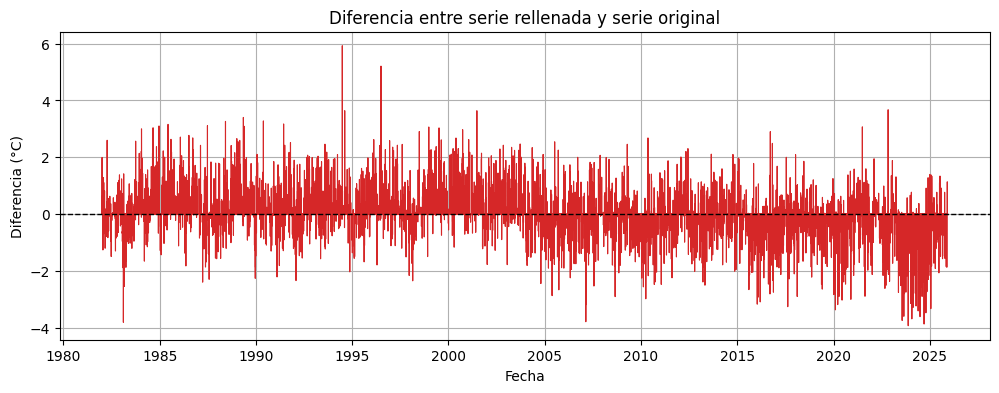

In [ ]:
plt.figure(figsize=(12,4))

plt.plot(
    df["fecha"],
    df["temp_rellena_media"] - df["temp_original"],
    color="tab:red",
    linewidth=0.8
)

plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.xlabel("Fecha")
plt.ylabel("Diferencia (°C)")
plt.title("Diferencia entre serie rellenada y serie original")
plt.grid(True)

plt.show()


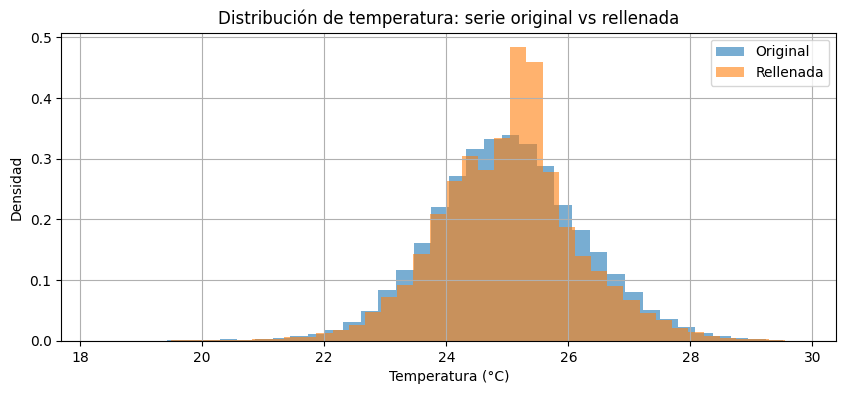

In [ ]:
plt.figure(figsize=(10,4))

plt.hist(
    df["temp_original"],
    bins=40,
    alpha=0.6,
    label="Original",
    density=True
)

plt.hist(
    df["temp_rellena_media"],
    bins=40,
    alpha=0.6,
    label="Rellenada",
    density=True
)

plt.xlabel("Temperatura (°C)")
plt.ylabel("Densidad")
plt.title("Distribución de temperatura: serie original vs rellenada")
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
df.to_csv(
    "temperatura_diaria_rellena_media_climatologica.csv",
    index=False
)

print("Archivo guardado: temperatura_diaria_rellena_media_climatologica.csv")


Archivo guardado: temperatura_diaria_rellena_media_climatologica.csv
